# 1. Load index

In [1]:
import genomics_data_index

print(genomics_data_index.__version__)

0.4.0.dev1


In [2]:
import genomics_data_index.api as gdi

db = gdi.GenomicsDataIndex.connect('cases/unset/index')
db

<GenomicsDataIndex(samples=22)>

# 2. Load metadata

In [3]:
import pandas as pd

metadata_df = pd.read_csv('metadata.tsv', sep='\t')
metadata_df['cluster'] = metadata_df['outbreak']
metadata_df.loc[metadata_df['cluster'] == 'outgroup', 'cluster'] = pd.NA
metadata_df

,dataSetName,strain,outbreak,SRArun_acc,cluster
0,0810PADBR-1,D5663,outgroup_0810PADBR-1,SRR1999649,outgroup_0810PADBR-1
1,0810PADBR-1,D7321,0810PADBR-1,SRR3215135,0810PADBR-1
2,0810PADBR-1,D7331,0810PADBR-1,SRR3214715,0810PADBR-1
3,0810PADBR-1,D7319,0810PADBR-1,SRR3215210,0810PADBR-1
4,0810PADBR-1,D7323,0810PADBR-1,SRR3215124,0810PADBR-1
...,...,...,...,...,...
80,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN000970,1203NYJAP-1,SRR498444,1203NYJAP-1
81,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN001112,1203NYJAP-1,SRR1258439,1203NYJAP-1
82,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN001115,1203NYJAP-1,SRR1258442,1203NYJAP-1
83,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN001118,1203NYJAP-1,SRR1258443,1203NYJAP-1


# 3. Kmer tree

In [4]:
q = db.samples_query().join(metadata_df, sample_names_column='strain')
q

<DataFrameSamplesQuery[selected=100% (22/22) samples, unknown=0% (0/22) samples]>

In [5]:
qkmer_31 = q.build_tree(kind='kmer', kmer_size=31)
qkmer_31

<KmerTreeSamplesQuery[selected=100% (22/22) samples, unknown=0% (0/22) samples]>

In [6]:
q_campy = qkmer_31.isa('0810PADBR-1', isa_column='dataSetName', kind='dataframe')
q_ecoli = qkmer_31.isa('1405WAEXK-1', isa_column='dataSetName', kind='dataframe')
q_listeria = qkmer_31.isa('1408MLGX6-3WGS', isa_column='dataSetName', kind='dataframe')
q_salmonella = qkmer_31.isa('1203NYJAP-1 - Tuna Scrape Outbreak', isa_column='dataSetName', kind='dataframe')

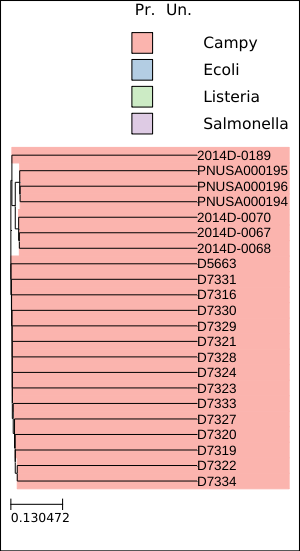

In [7]:
qkmer_31.tree_styler()\
 .highlight(q_campy, legend_label='Campy')\
 .highlight(q_ecoli, legend_label='Ecoli')\
 .highlight(q_listeria, legend_label='Listeria')\
 .highlight(q_salmonella, legend_label='Salmonella')\
 .render(w=300)

In [8]:
from genomics_data_index.api.query.impl.ClusterScorer import ClusterScorer

min_samples_cluster = 2

scorer = ClusterScorer(qkmer_31)
scores_organism = scorer.score_groupby(groupby_column='dataSetName', min_samples_count=min_samples_cluster)
scores_organism

,Score,Sample Count
dataSetName,,
0810PADBR-1,1.0,22


In [9]:
scores_outbreak = scorer.score_groupby(groupby_column='cluster', min_samples_count=min_samples_cluster)
scores_outbreak

,Score,Sample Count
cluster,,
0810PADBR-1,1.000000,14
outgroup_0810PADBR-1,0.363636,8


# ML Tree

In [10]:
db.reference_names()

['GCA_001879185.2_ASM187918v2_genomic']

In [24]:
t = db.samples_query(reference_name='GCA_001879185.2_ASM187918v2_genomic', universe='mutations')\
      .set_outgroup('D7331')\
      .join(metadata_df, sample_names_column='strain')
t

<MutationTreeSamplesQuery[selected=100% (22/22) samples, unknown=0% (0/22) samples]>

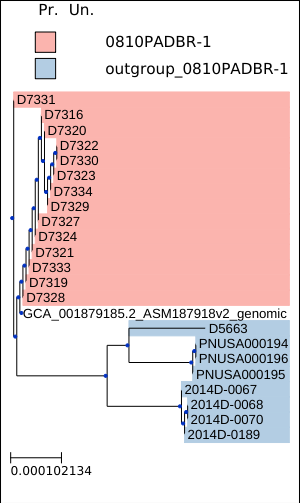

In [25]:
t.tree_styler()\
 .highlight(t.isa('0810PADBR-1', isa_column='outbreak', kind='dataframe'), legend_label='0810PADBR-1')\
 .highlight(t.isa('outgroup_0810PADBR-1', isa_column='outbreak', kind='dataframe'), legend_label='outgroup_0810PADBR-1')\
 .render(w=300)

In [26]:
scorer_ml = ClusterScorer(t)
scores_outbreak = scorer_ml.score_groupby(groupby_column='cluster', min_samples_count=min_samples_cluster)
scores_outbreak

,Score,Sample Count
cluster,,
0810PADBR-1,0.636364,14
outgroup_0810PADBR-1,1.000000,8


In [27]:
t.isa('0810PADBR-1', isa_column='outbreak', kind='dataframe').features_summary(selection='unique').sort_values('Count', ascending=False)

,Sequence,Position,Deletion,Insertion,Type,Count,Total,Percent,Annotation,Annotation_Impact,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,
CP069124.1:1190591:A:AC,CP069124.1,1190591,A,AC,INDEL,14,14,100.000000,frameshift_variant,HIGH,A0X86_006255,A0X86_006255,transcript,protein_coding,c.306dupG,p.Y103fs,hgvs:CP069124.1:A0X86_006255:c.306dupG,hgvs:CP069124.1:A0X86_006255:p.Y103fs,hgvs_gn:CP069124.1:A0X86_006255:c.306dupG,hgvs_gn:CP069124.1:A0X86_006255:p.Y103fs
CP069124.1:1376739:T:TG,CP069124.1,1376739,T,TG,INDEL,11,14,78.571429,frameshift_variant,HIGH,A0X86_007190,A0X86_007190,transcript,protein_coding,c.134dupG,p.I46fs,hgvs:CP069124.1:A0X86_007190:c.134dupG,hgvs:CP069124.1:A0X86_007190:p.I46fs,hgvs_gn:CP069124.1:A0X86_007190:c.134dupG,hgvs_gn:CP069124.1:A0X86_007190:p.I46fs
CP069124.1:1364330:T:TG,CP069124.1,1364330,T,TG,INDEL,9,14,64.285714,frameshift_variant,HIGH,A0X86_007130,A0X86_007130,transcript,protein_coding,c.673dupG,p.D225fs,hgvs:CP069124.1:A0X86_007130:c.673dupG,hgvs:CP069124.1:A0X86_007130:p.D225fs,hgvs_gn:CP069124.1:A0X86_007130:c.673dupG,hgvs_gn:CP069124.1:A0X86_007130:p.D225fs
CP069124.1:741372:A:AG,CP069124.1,741372,A,AG,INDEL,6,14,42.857143,frameshift_variant,HIGH,kdpB,A0X86_003980,transcript,protein_coding,c.807dupG,p.L270fs,hgvs:CP069124.1:A0X86_003980:c.807dupG,hgvs:CP069124.1:A0X86_003980:p.L270fs,hgvs_gn:CP069124.1:kdpB:c.807dupG,hgvs_gn:CP069124.1:kdpB:p.L270fs
CP069124.1:1369265:C:T,CP069124.1,1369265,C,T,SNP,1,14,7.142857,missense_variant,MODERATE,legG,A0X86_007155,transcript,protein_coding,c.1058C>T,p.P353L,hgvs:CP069124.1:A0X86_007155:c.1058C>T,hgvs:CP069124.1:A0X86_007155:p.P353L,hgvs_gn:CP069124.1:legG:c.1058C>T,hgvs_gn:CP069124.1:legG:p.P353L
CP069124.1:1348343:A:AC,CP069124.1,1348343,A,AC,INDEL,1,14,7.142857,frameshift_variant,HIGH,A0X86_007050,A0X86_007050,transcript,protein_coding,c.585dupG,p.S196fs,hgvs:CP069124.1:A0X86_007050:c.585dupG,hgvs:CP069124.1:A0X86_007050:p.S196fs,hgvs_gn:CP069124.1:A0X86_007050:c.585dupG,hgvs_gn:CP069124.1:A0X86_007050:p.S196fs
CP069124.1:1365317:T:TGG,CP069124.1,1365317,T,TGG,INDEL,1,14,7.142857,frameshift_variant,HIGH,A0X86_007135,A0X86_007135,transcript,protein_coding,c.961_962dupGG,p.S322fs,hgvs:CP069124.1:A0X86_007135:c.961_962dupGG,hgvs:CP069124.1:A0X86_007135:p.S322fs,hgvs_gn:CP069124.1:A0X86_007135:c.961_962dupGG,hgvs_gn:CP069124.1:A0X86_007135:p.S322fs
CP069124.1:807524:TC:T,CP069124.1,807524,TC,T,INDEL,1,14,7.142857,intron_variant,MODIFIER,hisA,A0X86_000005,transcript,protein_coding,c.350+807175delC,<NA>,hgvs:CP069124.1:A0X86_000005:c.350+807175delC,<NA>,hgvs_gn:CP069124.1:hisA:c.350+807175delC,<NA>


In [32]:
df = t.isa('D7331').features_summary()
# df[df['Type'] != 'INDEL']
df

,Sequence,Position,Deletion,Insertion,Type,Count,Total,Percent,Annotation,Annotation_Impact,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,
CP069124.1:1286369:A:AC,CP069124.1,1286369,A,AC,INDEL,1,1,100.0,frameshift_variant,HIGH,uvrC,A0X86_006750,transcript,protein_coding,c.1686dupG,p.L563fs,hgvs:CP069124.1:A0X86_006750:c.1686dupG,hgvs:CP069124.1:A0X86_006750:p.L563fs,hgvs_gn:CP069124.1:uvrC:c.1686dupG,hgvs_gn:CP069124.1:uvrC:p.L563fs
CP069124.1:777073:C:CA,CP069124.1,777073,C,CA,INDEL,1,1,100.0,frameshift_variant,HIGH,A0X86_004135,A0X86_004135,transcript,protein_coding,c.528dupA,p.P177fs,hgvs:CP069124.1:A0X86_004135:c.528dupA,hgvs:CP069124.1:A0X86_004135:p.P177fs,hgvs_gn:CP069124.1:A0X86_004135:c.528dupA,hgvs_gn:CP069124.1:A0X86_004135:p.P177fs
CP069124.1:642760:G:GA,CP069124.1,642760,G,GA,INDEL,1,1,100.0,intron_variant,MODIFIER,hisA,A0X86_000005,transcript,protein_coding,c.350+642410_350+642411insA,<NA>,hgvs:CP069124.1:A0X86_000005:c.350+642410_350+...,<NA>,hgvs_gn:CP069124.1:hisA:c.350+642410_350+64241...,<NA>
CP069124.1:802941:C:CA,CP069124.1,802941,C,CA,INDEL,1,1,100.0,frameshift_variant,HIGH,A0X86_004280,A0X86_004280,transcript,protein_coding,c.1706dupA,p.E570fs,hgvs:CP069124.1:A0X86_004280:c.1706dupA,hgvs:CP069124.1:A0X86_004280:p.E570fs,hgvs_gn:CP069124.1:A0X86_004280:c.1706dupA,hgvs_gn:CP069124.1:A0X86_004280:p.E570fs
CP069124.1:685696:A:AT,CP069124.1,685696,A,AT,INDEL,1,1,100.0,intron_variant,MODIFIER,hisA,A0X86_000005,transcript,protein_coding,c.350+685346_350+685347insT,<NA>,hgvs:CP069124.1:A0X86_000005:c.350+685346_350+...,<NA>,hgvs_gn:CP069124.1:hisA:c.350+685346_350+68534...,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CP069124.1:1375469:A:AT,CP069124.1,1375469,A,AT,INDEL,1,1,100.0,frameshift_variant,HIGH,A0X86_007185,A0X86_007185,transcript,protein_coding,c.770dupT,p.L257fs,hgvs:CP069124.1:A0X86_007185:c.770dupT,hgvs:CP069124.1:A0X86_007185:p.L257fs,hgvs_gn:CP069124.1:A0X86_007185:c.770dupT,hgvs_gn:CP069124.1:A0X86_007185:p.L257fs
CP069124.1:896670:A:AT,CP069124.1,896670,A,AT,INDEL,1,1,100.0,frameshift_variant,HIGH,A0X86_004740,A0X86_004740,transcript,protein_coding,c.347dupT,p.L116fs,hgvs:CP069124.1:A0X86_004740:c.347dupT,hgvs:CP069124.1:A0X86_004740:p.L116fs,hgvs_gn:CP069124.1:A0X86_004740:c.347dupT,hgvs_gn:CP069124.1:A0X86_004740:p.L116fs
CP069124.1:642372:G:GA,CP069124.1,642372,G,GA,INDEL,1,1,100.0,intron_variant,MODIFIER,hisA,A0X86_000005,transcript,protein_coding,c.350+642022_350+642023insA,<NA>,hgvs:CP069124.1:A0X86_000005:c.350+642022_350+...,<NA>,hgvs_gn:CP069124.1:hisA:c.350+642022_350+64202...,<NA>


In [28]:
t.isa('outgroup_0810PADBR-1', isa_column='outbreak', kind='dataframe').features_summary(selection='unique').sort_values('Count', ascending=False)

,Sequence,Position,Deletion,Insertion,Type,Count,Total,Percent,Annotation,Annotation_Impact,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,
CP069124.1:403399:G:A,CP069124.1,403399,G,A,SNP,8,8,100.0,synonymous_variant,LOW,fliG,A0X86_002200,transcript,protein_coding,c.627G>A,p.A209A,hgvs:CP069124.1:A0X86_002200:c.627G>A,hgvs:CP069124.1:A0X86_002200:p.A209A,hgvs_gn:CP069124.1:fliG:c.627G>A,hgvs_gn:CP069124.1:fliG:p.A209A
CP069124.1:199395:C:T,CP069124.1,199395,C,T,SNP,8,8,100.0,intron_variant,MODIFIER,hisA,A0X86_000005,transcript,protein_coding,c.350+199045C>T,<NA>,hgvs:CP069124.1:A0X86_000005:c.350+199045C>T,<NA>,hgvs_gn:CP069124.1:hisA:c.350+199045C>T,<NA>
CP069124.1:207076:G:A,CP069124.1,207076,G,A,SNP,8,8,100.0,intron_variant,MODIFIER,hisA,A0X86_000005,transcript,protein_coding,c.350+206726G>A,<NA>,hgvs:CP069124.1:A0X86_000005:c.350+206726G>A,<NA>,hgvs_gn:CP069124.1:hisA:c.350+206726G>A,<NA>
CP069124.1:206093:T:C,CP069124.1,206093,T,C,SNP,8,8,100.0,synonymous_variant,LOW,A0X86_001110,A0X86_001110,transcript,protein_coding,c.381T>C,p.N127N,hgvs:CP069124.1:A0X86_001110:c.381T>C,hgvs:CP069124.1:A0X86_001110:p.N127N,hgvs_gn:CP069124.1:A0X86_001110:c.381T>C,hgvs_gn:CP069124.1:A0X86_001110:p.N127N
CP069124.1:404411:C:T,CP069124.1,404411,C,T,SNP,8,8,100.0,synonymous_variant,LOW,fliH,A0X86_002205,transcript,protein_coding,c.603C>T,p.A201A,hgvs:CP069124.1:A0X86_002205:c.603C>T,hgvs:CP069124.1:A0X86_002205:p.A201A,hgvs_gn:CP069124.1:fliH:c.603C>T,hgvs_gn:CP069124.1:fliH:p.A201A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CP069124.1:164992:T:C,CP069124.1,164992,T,C,SNP,1,8,12.5,missense_variant,MODERATE,A0X86_000875,A0X86_000875,transcript,protein_coding,c.431A>G,p.N144S,hgvs:CP069124.1:A0X86_000875:c.431A>G,hgvs:CP069124.1:A0X86_000875:p.N144S,hgvs_gn:CP069124.1:A0X86_000875:c.431A>G,hgvs_gn:CP069124.1:A0X86_000875:p.N144S
CP069124.1:301793:C:T,CP069124.1,301793,C,T,SNP,1,8,12.5,synonymous_variant,LOW,A0X86_001655,A0X86_001655,transcript,protein_coding,c.1053G>A,p.P351P,hgvs:CP069124.1:A0X86_001655:c.1053G>A,hgvs:CP069124.1:A0X86_001655:p.P351P,hgvs_gn:CP069124.1:A0X86_001655:c.1053G>A,hgvs_gn:CP069124.1:A0X86_001655:p.P351P
CP069124.1:301483:T:C,CP069124.1,301483,T,C,SNP,1,8,12.5,missense_variant,MODERATE,A0X86_001650,A0X86_001650,transcript,protein_coding,c.119A>G,p.E40G,hgvs:CP069124.1:A0X86_001650:c.119A>G,hgvs:CP069124.1:A0X86_001650:p.E40G,hgvs_gn:CP069124.1:A0X86_001650:c.119A>G,hgvs_gn:CP069124.1:A0X86_001650:p.E40G
